# Investigating connection between persistent homology and eigenvalue decomposition of (normalized) Laplacian matrix
- Is it possible to go directly from the weighted adjacency matrix to a barcode diagram/persistent homology?
 - Calculcate eigenvalues of normalized Laplacian matrix using the weighted adjacency matrix
 - Compute persistent $H_0$ of data set and compute barcode diagram & compare to eigenvalues

In [2]:
from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# data
import numpy as np
from db import DB
import pandas as pd
import random

import dionysus

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [241]:
import numpy as np
from numpy.linalg import svd


def rank(A, atol=1e-13, rtol=0):
    """Estimate the rank (i.e. the dimension of the nullspace) of a matrix.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length n will be treated
        as a 2-D with shape (1, n)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    r : int
        The estimated rank of the matrix.

    See also
    --------
    numpy.linalg.matrix_rank
        matrix_rank is basically the same as this function, but it does not
        provide the option of the absolute tolerance.
    """

    A = np.atleast_2d(A)
    s = svd(A, compute_uv=False)
    tol = max(atol, rtol * s[0])
    rank = int((s >= tol).sum())
    return rank


def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

## Noisy circle

In [195]:
n_pts = 100
rrnd = 0.5
alpha = [0.4, 0.6, 0.2, 0.4]

pc = [[np.cos(x*np.pi) + alpha[0]*random.random(), np.sin(x*np.pi) + alpha[1]*random.random()] for 
      x in [(r + random.random()*rrnd)*(1/float(n_pts)) for r in range(-n_pts, n_pts)]]

In [196]:
pc2 = [[x+2, y] for (x, y) in pc]

In [197]:
pcdf = pd.DataFrame(pc + pc2)

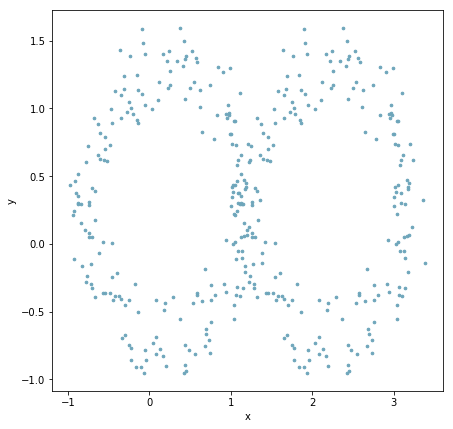

In [198]:
pcdf.rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    c='#6DA5BA',
    s=7
);

## Persistent Homology

In [199]:
%%time
filtration = dionysus.fill_rips(np.array(pc+pc2), 2, 1.0)

CPU times: user 2.21 s, sys: 96.5 ms, total: 2.31 s
Wall time: 2.3 s


In [200]:
%%time
persistence = dionysus.homology_persistence(filtration)

CPU times: user 4.58 s, sys: 27.7 ms, total: 4.61 s
Wall time: 4.59 s


In [201]:
%%time
dgms = dionysus.init_diagrams(persistence, filtration)

CPU times: user 25.6 ms, sys: 2.07 ms, total: 27.7 ms
Wall time: 27.5 ms


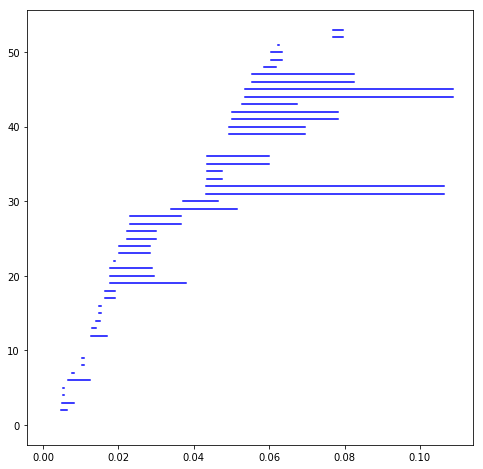

In [203]:
plt.figure(figsize=(8, 8));

dionysus.plot.plot_bars(dgm=dgms[1], show=True);

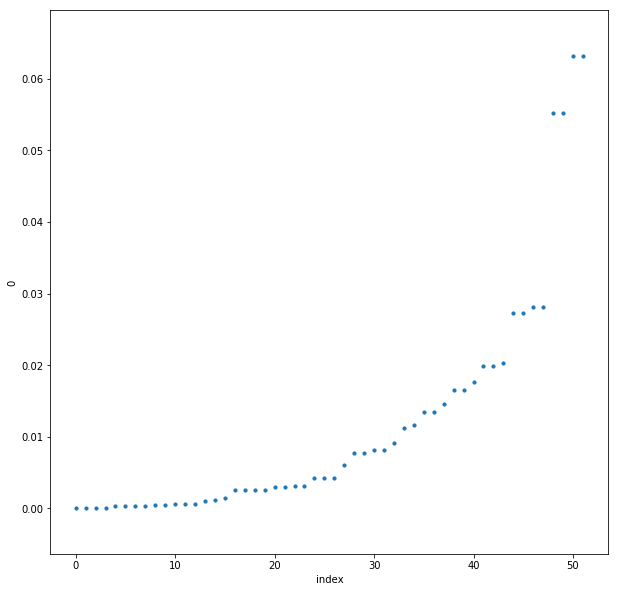

In [204]:
pd.DataFrame(sorted([abs(point.birth - point.death) for point in dgms[1]])).reset_index().plot(
    kind='scatter',
    x='index',
    y=0,
    figsize=(10, 10),
    s=10
);

## Eigenvalue decomposition

In [205]:
from numpy.linalg import svd, eig
from scipy.spatial import distance_matrix
from scipy.linalg import fractional_matrix_power

In [206]:
%%time

weighted_adjacency = distance_matrix(x=pc+pc2, y=pc+pc2)

CPU times: user 6.86 ms, sys: 1.74 ms, total: 8.6 ms
Wall time: 6.84 ms


In [230]:
weighted_adjacency = weighted_adjacency/weighted_adjacency.max()

## Eigenvalue decomposition with tensors

In [246]:
%%time

laplacian_tensor = np.array([
    np.diag((weighted_adjacency <= epsilon).astype(int).sum(axis=0)) \
    - (weighted_adjacency <= epsilon).astype(int) 
    for epsilon in [x*0.01 for x in range(50)]
])

CPU times: user 61.3 ms, sys: 55.4 ms, total: 117 ms
Wall time: 116 ms


In [247]:
laplacian_tensor.shape

(50, 400, 400)

In [248]:
%%time

w_tensor, v_tensor = eig(laplacian_tensor)

CPU times: user 12 s, sys: 245 ms, total: 12.2 s
Wall time: 3.11 s


In [249]:
%%time

w_tensor, v_tensor = np.real(w_tensor), np.real(v_tensor)

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 16 µs


In [250]:
w_tensor.shape
v_tensor.shape

(50, 400)

(50, 400, 400)

In [252]:
%%time

np.array([np.count_nonzero(w_tensor[i] <= 1e-10) for i in range(50)])

CPU times: user 171 µs, sys: 1e+03 ns, total: 172 µs
Wall time: 179 µs


array([400, 317, 150,  47,  16,   2,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1])

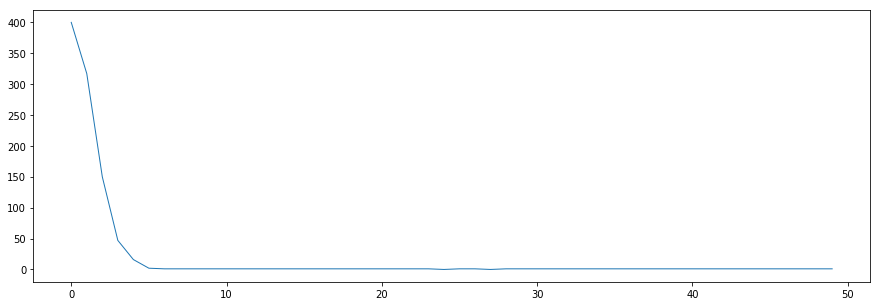

In [254]:
pd.Series([np.count_nonzero(w_tensor[i] <= 1e-13) for i in range(50)]).plot(
    kind='line',
    figsize=(15, 5),
    lw=1
);

In [257]:
laplacian_1_mtx = np.array([
    np.array([2, 1, -1, 0, 0, 0, 0]),
    np.array([1, 2, 1, -1, 0, 0, 0]),
    np.array([-1, 1, 2, -1, 0, 0, 0]),
    np.array([0, -1, -1, 2, 1, 0, -1]),
    np.array([0, 0, 0, 1, 2, 1, -1]),
    np.array([0, 0, 0, 0, 1, 2, 1]),
    np.array([0, 0, 0, -1, -1, 1, 2])
])

In [258]:
laplacian_1_mtx

array([[ 2,  1, -1,  0,  0,  0,  0],
       [ 1,  2,  1, -1,  0,  0,  0],
       [-1,  1,  2, -1,  0,  0,  0],
       [ 0, -1, -1,  2,  1,  0, -1],
       [ 0,  0,  0,  1,  2,  1, -1],
       [ 0,  0,  0,  0,  1,  2,  1],
       [ 0,  0,  0, -1, -1,  1,  2]])

In [260]:
nullspace(laplacian_1_mtx, atol=1e-10).shape

(7, 2)

## Tensor decomposition of laplacian tensor
Will this give a way to choose the "most" persistent elements of $H_0$ without having to inspect the Betti sequence?